# 1. Importing Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from tld import get_tld # https://pypi.org/project/tld/
from sklearn.model_selection import train_test_split

# 2. Dataset Preprocessing

In [2]:
df = pd.read_csv('malicious_urls.csv', header=0)
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


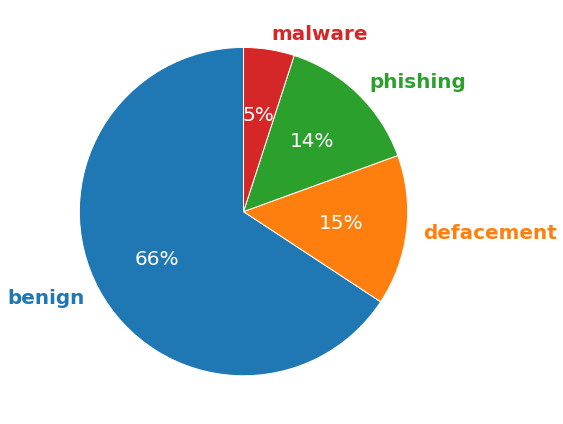

In [3]:
# Pie chart of the label

fig, ax = plt.subplots(figsize=(8, 6))
patches, texts, pcts = ax.pie(
    df['type'].value_counts(), labels=df['type'].value_counts().index, autopct='%.f%%',
    wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
    textprops={"fontsize": 20},
    startangle=90)
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
plt.tight_layout()
plt.show()

In [4]:
# Turn categorical values into numerical values
# If the type of URL is milacious, then it gets "1"

dic = {"target": {"benign": 0, "defacement": 1, "phishing":1, "malware":1}}
df['target'] = df['type']
df = df.replace(dic)
df.head()

,url,type,target
0,br-icloud.com.br,phishing,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


# 3. Feature Construction

The web address can be decomposed into several parts, for example:

<div>
   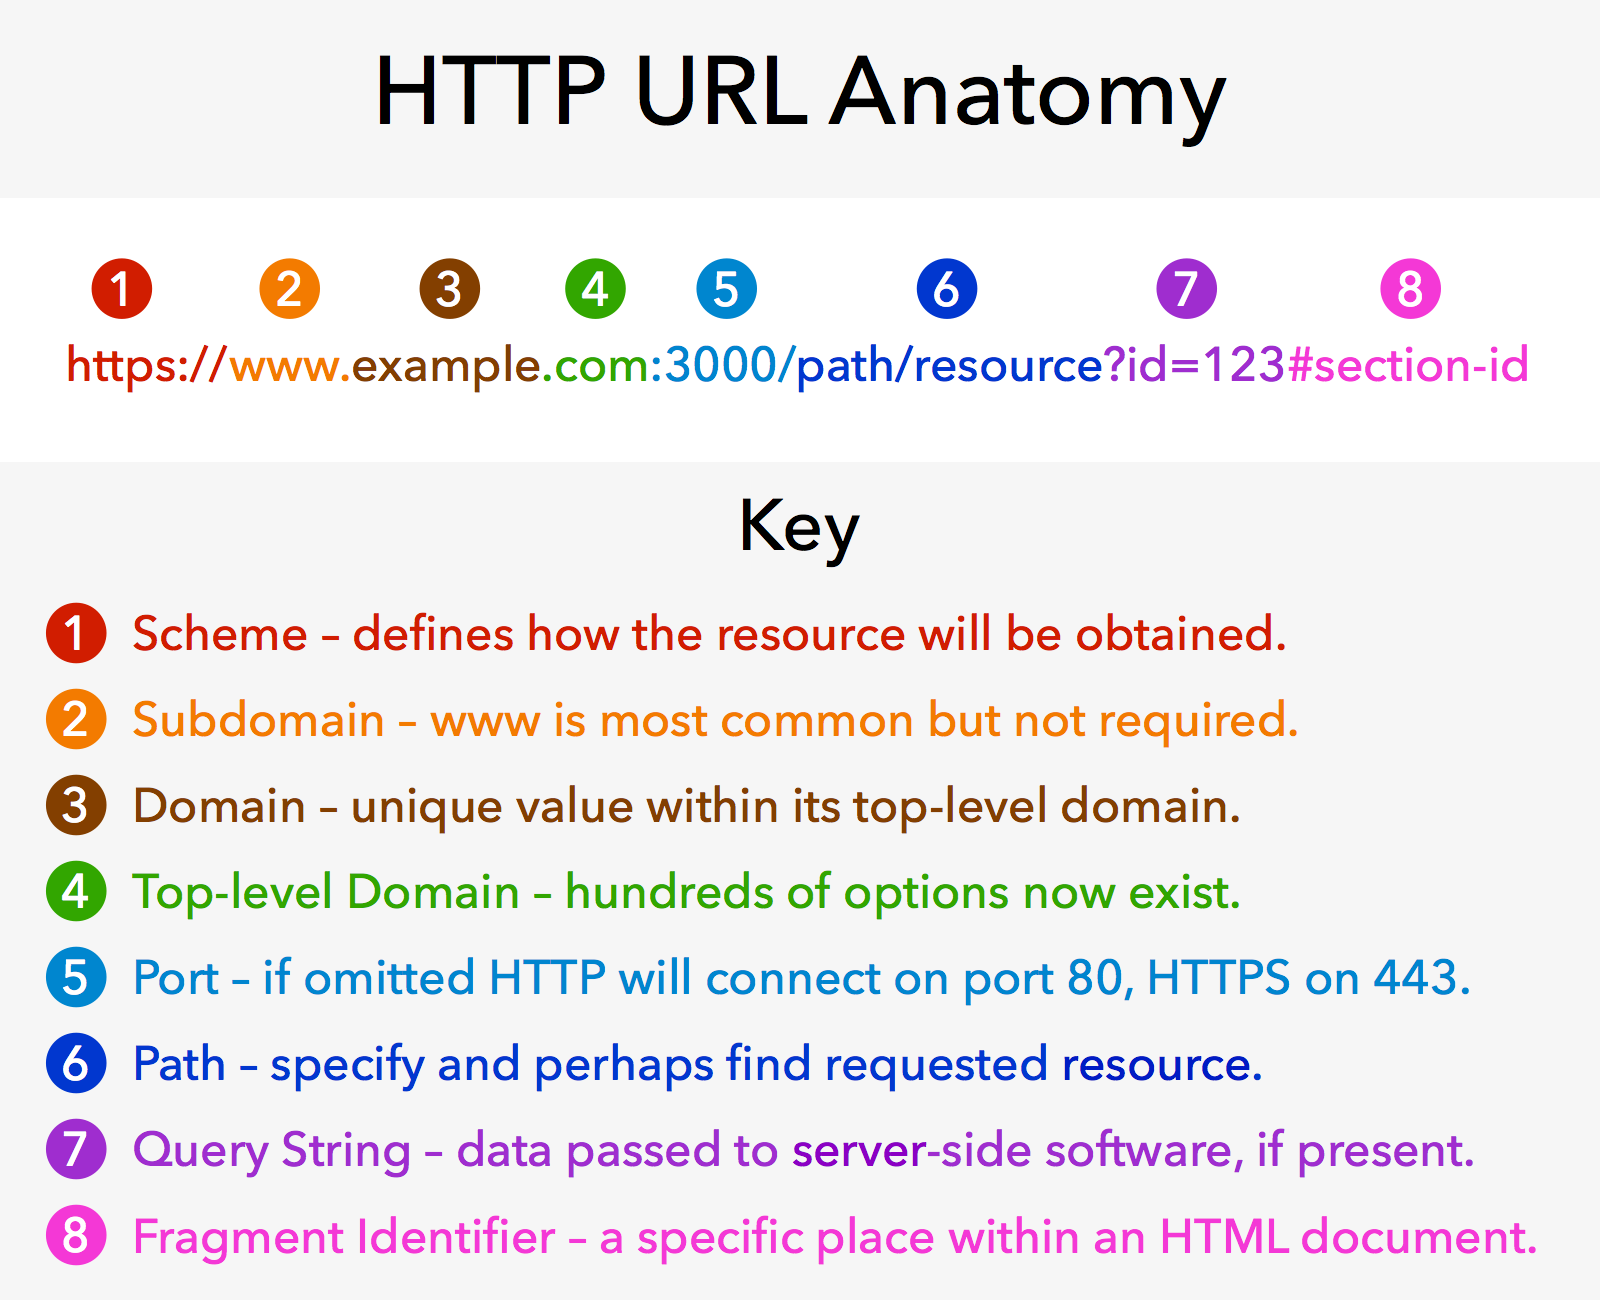
</div>

source: https://www.pinterest.com/pin/141230138290661195/

In [5]:
# Create features

# Length of the URL
df['url_len'] = df['url'].apply(lambda i: len(str(i)))

# The number of common scheme and subdomain
df['http'] = df['url'].apply(lambda i: i.count('http'))
df['https'] = df['url'].apply(lambda i: i.count('https'))
df['www'] = df['url'].apply(lambda i: i.count('www'))

# Length of the path
def path_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0
df['path_len'] = df['url'].apply(lambda i: path_length(i))

# Length of the TLD and whether the URL contains a known TLD
known_tld_list = ["com","org","net","edu","gov","int","mil","us","ca","cn","fr","au","de","jp","nl","uk","mx","no","ru","br","se","es","co","tw"]
def tld_length(url):
    tld = get_tld(url,fail_silently=True)
    try:
        return len(tld)
    except:
        return 0
def known_tld(url):
    tld = get_tld(url,fail_silently=True)
    if tld in known_tld_list:
        return 1
    else:
        return 0
df['tld_len'] = df['url'].apply(lambda i: tld_length(i))
df['known_tld'] = df['url'].apply(lambda i: known_tld(i))


# The number of special symbols
df['and'] = df['url'].apply(lambda i: i.count('&'))
df['backslash'] = df['url'].apply(lambda i: i.count('\\'))
df['comma'] = df['url'].apply(lambda i: i.count(','))
df['dash'] = df['url'].apply(lambda i: i.count('-'))
df['dot'] = df['url'].apply(lambda i: i.count('.'))
df['exclamation'] = df['url'].apply(lambda i: i.count('!'))
df['hashtag'] = df['url'].apply(lambda i: i.count('#'))
df['mouse'] = df['url'].apply(lambda i: i.count('@'))
df['percent'] = df['url'].apply(lambda i: i.count('%'))
df['plus'] = df['url'].apply(lambda i: i.count('+'))
df['question'] = df['url'].apply(lambda i: i.count('?'))
df['semicolon'] = df['url'].apply(lambda i: i.count(';'))                                                    
df['slash'] = df['url'].apply(lambda i: i.count('/'))
df['tilde'] = df['url'].apply(lambda i: i.count('~'))
df['underline'] = df['url'].apply(lambda i: i.count('_'))

# Whether an ip address is in the URL
# This function is taken from @sid321xan notebook on Kaggle
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
df['ip'] = df['url'].apply(lambda i: having_ip_address(i))

# Whether the URL contain a shortening service
# This function is taken from @sid321xan notebook on Kaggle
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['shorten'] = df['url'].apply(lambda i: shortening_service(i))

# The number of digits in the URL
# This function is taken from @sid321xan notebook on Kaggle
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['digit']= df['url'].apply(lambda i: digit_count(i))

# The number of letters in the URL
# This function is taken from @sid321xan notebook on Kaggle
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['letter']= df['url'].apply(lambda i: letter_count(i))                       

In [6]:
X = df.drop(labels=['url', 'type', 'target'], axis=1)
y = df['target']

In [7]:
# Summary statistics of all features
pd.set_option('display.max_columns', 30)
X.describe()

,url_len,http,https,www,path_len,tld_len,known_tld,and,backslash,comma,dash,dot,exclamation,hashtag,mouse,percent,plus,question,semicolon,slash,tilde,underline,ip,shorten,digit,letter
count,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000
mean,60.156831,0.296738,0.025656,0.195379,8.843092,0.844066,0.181279,0.380497,0.024819,0.004823,1.550421,2.195453,0.000954,0.000871,0.002219,0.519502,0.068432,0.223782,0.038896,2.950265,0.013451,0.423026,0.019177,0.061050,5.527409,45.247104
std,44.753902,0.470894,0.161594,0.402825,11.866224,1.577038,0.385249,1.224169,0.453892,0.152428,2.973790,1.490732,0.039546,0.032327,0.054183,4.462254,0.621276,0.441220,0.558691,1.904187,0.117740,1.173615,0.137147,0.239422,11.700814,31.624502
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,47.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,37.000000
75%,77.000000,1.000000,0.000000,0.000000,9.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,7.000000,58.000000
max,2175.000000,9.000000,5.000000,5.000000,408.000000,39.000000,1.000000,50.000000,71.000000,15.000000,87.000000,42.000000,5.000000,6.000000,10.000000,231.000000,37.000000,20.000000,104.000000,41.000000,8.000000,79.000000,1.000000,1.000000,1204.000000,2141.000000


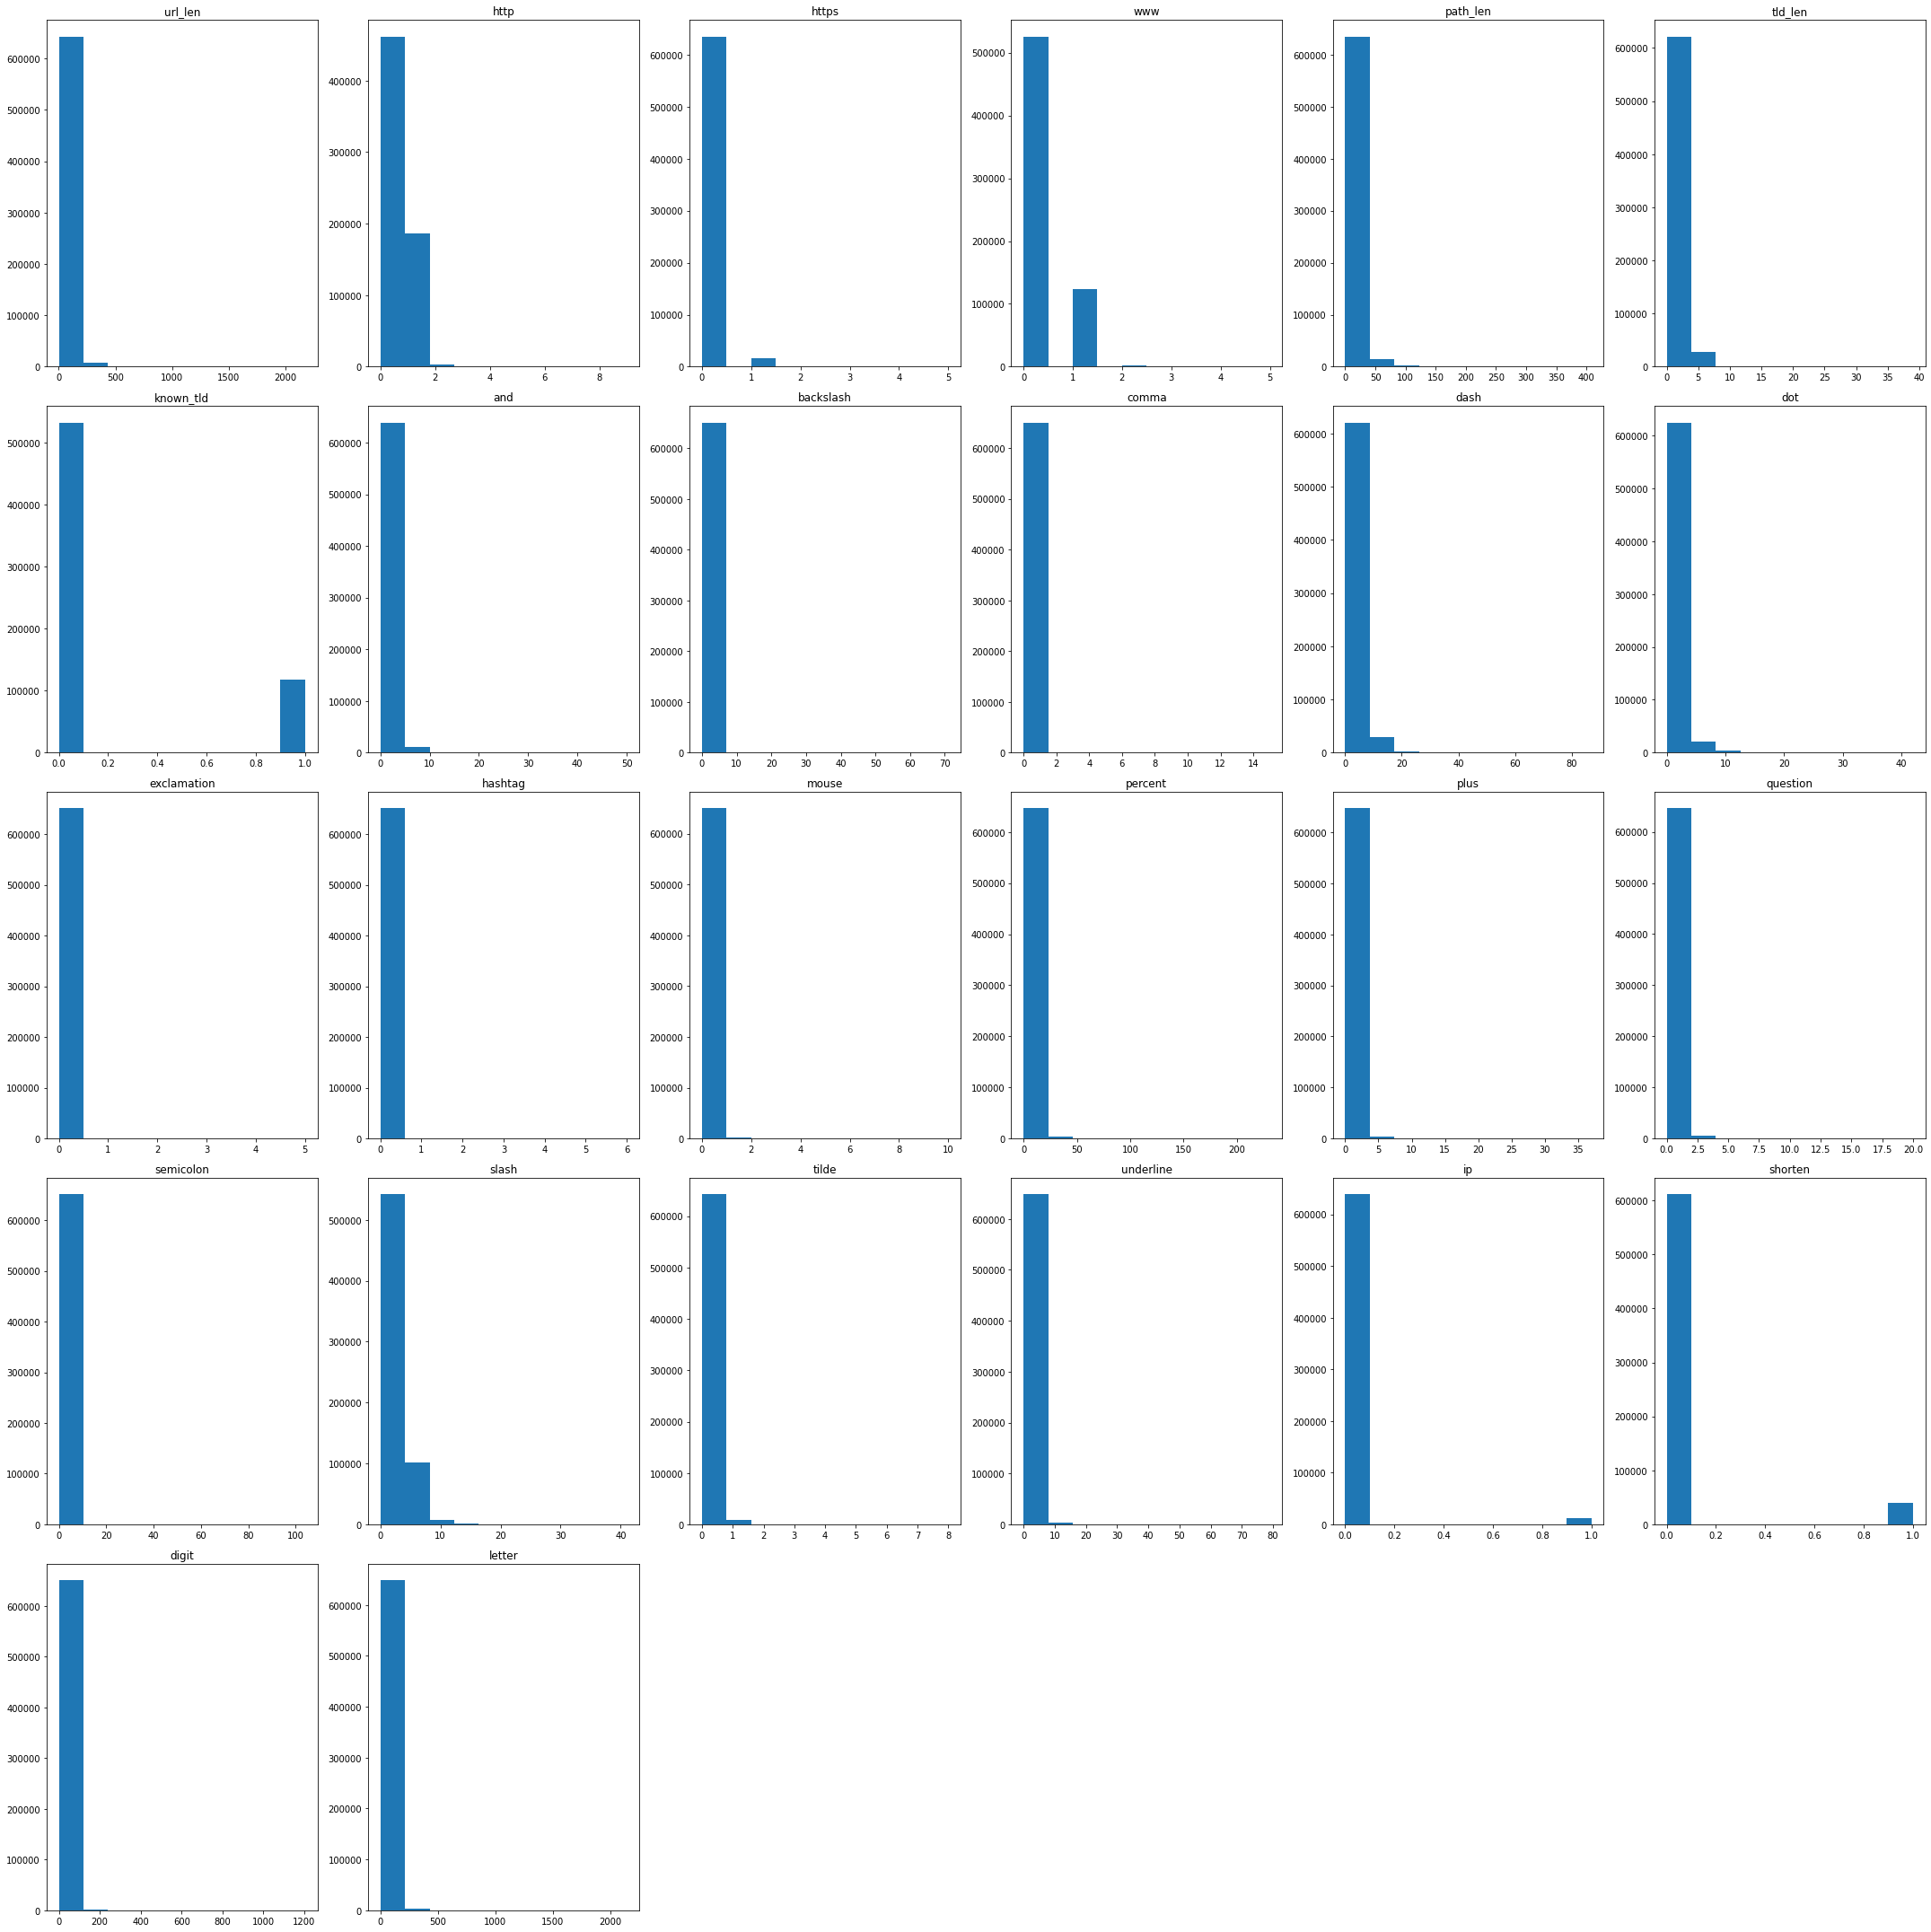

In [8]:
# Distribustion of all features
plt.figure(figsize=(30, 30))
for i in range(26):
    ax = plt.subplot(5, 6, i+1)
    try:
        ax.set_title(list(X.columns)[i])
        ax.hist(X.iloc[:,i])
    except:
        pass
plt.tight_layout()
plt.show()

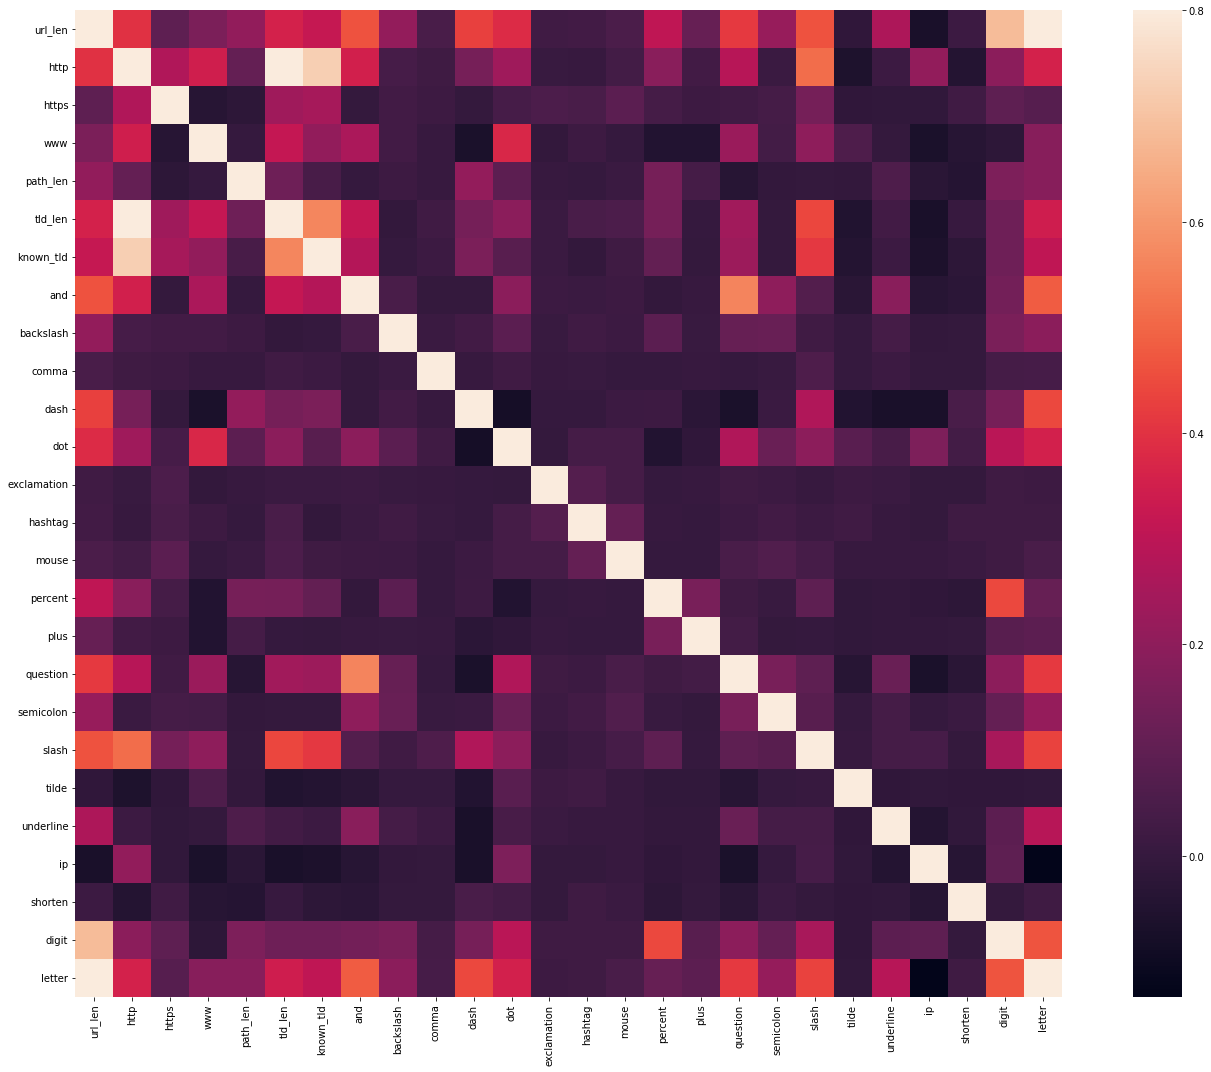

In [9]:
# Correlation heatmap
correlation_matrix = X.corr()
fig = plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.tight_layout()
plt.show()

# 4. Feature Engineering

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
scaler_X = scaler.transform(X)

X = pd.DataFrame(scaler_X, columns = X.columns)
X.head()

,url_len,http,https,www,path_len,tld_len,known_tld,and,backslash,comma,dash,dot,exclamation,hashtag,mouse,percent,plus,question,semicolon,slash,tilde,underline,ip,shorten,digit,letter
0,-0.986660,-0.630159,-0.158768,-0.485023,-0.745233,-0.535223,-0.470549,-0.310821,-0.054681,-0.031644,-0.185091,-0.131112,-0.024114,-0.026935,-0.040954,-0.116422,-0.110147,-0.507190,-0.069621,-1.549358,-0.114242,-0.360448,-0.139829,-0.254988,-0.472396,-1.019688
1,-0.562115,-0.630159,-0.158768,-0.485023,-0.323868,-0.535223,-0.470549,-0.310821,-0.054681,-0.031644,-0.521362,-0.131112,-0.024114,-0.026935,-0.040954,-0.116422,-0.110147,-0.507190,-0.069621,-0.499040,-0.114242,0.491621,-0.139829,-0.254988,-0.386931,-0.513751
2,-0.651493,-0.630159,-0.158768,-0.485023,-0.155323,-0.535223,-0.470549,-0.310821,-0.054681,-0.031644,-0.521362,-0.131112,-0.024114,-0.026935,-0.040954,-0.116422,-0.110147,-0.507190,-0.069621,0.026119,-0.114242,-0.360448,-0.139829,-0.254988,-0.386931,-0.640235
3,0.622140,1.493464,-0.158768,1.997449,0.013223,0.732979,-0.470549,2.139824,-0.054681,-0.031644,-0.185091,0.539700,-0.024114,-0.026935,-0.040954,-0.116422,-0.110147,1.759256,-0.069621,0.026119,-0.114242,1.343690,-0.139829,-0.254988,0.125854,0.561366
4,3.906772,1.493464,-0.158768,-0.485023,0.013223,1.367079,2.125175,1.322942,-0.054681,-0.031644,-0.185091,-0.131112,-0.024114,-0.026935,-0.040954,-0.116422,-0.110147,1.759256,-0.069621,0.026119,-0.114242,0.491621,-0.139829,-0.254988,1.407817,4.861832


In [11]:
# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=110352028)

# 5. Model Training

## Machine Learning Models

### Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

nb = GaussianNB().fit(X_train, y_train)

print(f'Cross Validation Score: {cross_val_score(nb, X_train, y_train).mean()}')
print(f'Accuracy: {nb.score(X_train, y_train)}')
print('Classification Report:')
print()
print(classification_report(y_train, nb.predict(X_train), digits=4))

Cross Validation Score: 0.8632812053085399
Accuracy: 0.8636020875687892
Classification Report:

              precision    recall  f1-score   support

           0     0.8864    0.9088    0.8975    286638
           1     0.8165    0.7770    0.7963    149659

    accuracy                         0.8636    436297
   macro avg     0.8515    0.8429    0.8469    436297
weighted avg     0.8624    0.8636    0.8628    436297



### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=110352028).fit(X_train, y_train)

print(f'Cross Validation Score: {cross_val_score(lr, X_train, y_train).mean()}')
print(f'Accuracy: {lr.score(X_train, y_train)}')
print('Classification Report:')
print()
print(classification_report(y_train, lr.predict(X_train), digits=4))

Cross Validation Score: 0.8984842883861173
Accuracy: 0.8984567851715689
Classification Report:

              precision    recall  f1-score   support

           0     0.8933    0.9601    0.9255    286638
           1     0.9108    0.7804    0.8406    149659

    accuracy                         0.8985    436297
   macro avg     0.9020    0.8703    0.8830    436297
weighted avg     0.8993    0.8985    0.8964    436297



### Decision Tree

In [14]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=110352028, max_depth=3).fit(X_train, y_train)

print(f'Cross Validation Score: {cross_val_score(dt, X_train, y_train).mean()}')
print(f'Accuracy: {dt.score(X_train, y_train)}')
print('Classification Report:')
print()
print(classification_report(y_train, dt.predict(X_train), digits=4))

Cross Validation Score: 0.912227218657032
Accuracy: 0.9122272213652627
Classification Report:

              precision    recall  f1-score   support

           0     0.9114    0.9597    0.9349    286638
           1     0.9141    0.8213    0.8652    149659

    accuracy                         0.9122    436297
   macro avg     0.9127    0.8905    0.9001    436297
weighted avg     0.9123    0.9122    0.9110    436297



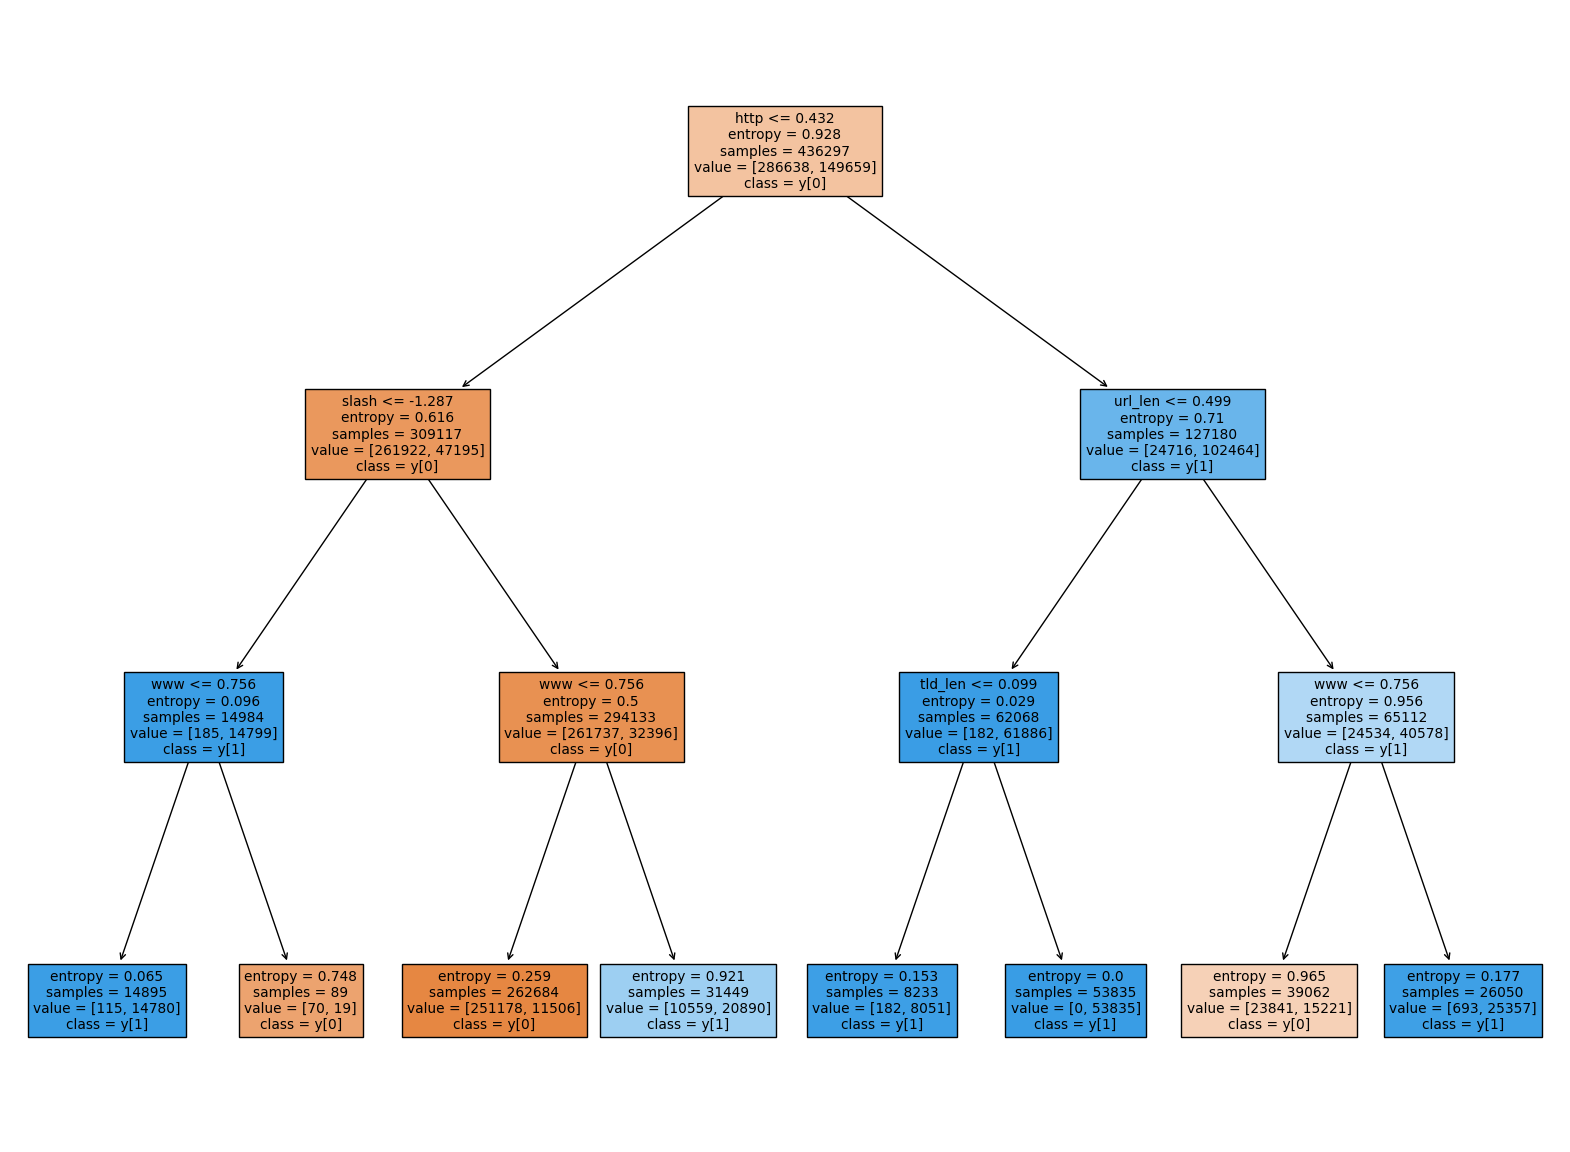

In [15]:
plt.figure(figsize = (20, 15), dpi=100)
tree.plot_tree(dt, feature_names=X.columns, class_names=True, filled=True)
plt.show()

### Random Forest

In [16]:
# It might takes around 2 minutes
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_split=10, max_features=10, n_jobs=-1, warm_start=True, random_state=110352028).fit(X_train, y_train)

print(f'Cross Validation Score: {cross_val_score(rf, X_train, y_train).mean()}')
print(f'Accuracy: {rf.score(X_train, y_train)}')
print('Classification Report:')
print()
print(classification_report(y_train, rf.predict(X_train), digits=4))

Cross Validation Score: 0.9195983606116658
Accuracy: 0.9253444328060931
Classification Report:

              precision    recall  f1-score   support

           0     0.9339    0.9539    0.9438    286638
           1     0.9080    0.8706    0.8889    149659

    accuracy                         0.9253    436297
   macro avg     0.9209    0.9123    0.9163    436297
weighted avg     0.9250    0.9253    0.9250    436297



### XGBoost

In [17]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, max_depth=3, random_state=110352028).fit(X_train, y_train) 

print(f'Cross Validation Score: {cross_val_score(xgb, X_train, y_train).mean()}')
print(f'Accuracy: {xgb.score(X_train, y_train)}')
print('Classification Report:')
print()
print(classification_report(y_train, xgb.predict(X_train), digits=4))

Cross Validation Score: 0.9640795137536038
Accuracy: 0.9644622814275596
Classification Report:

              precision    recall  f1-score   support

           0     0.9630    0.9837    0.9732    286638
           1     0.9674    0.9277    0.9471    149659

    accuracy                         0.9645    436297
   macro avg     0.9652    0.9557    0.9602    436297
weighted avg     0.9645    0.9645    0.9643    436297



## Neural Network Models

### Neural Network 1 (without early stopping, without dropout layer)

In [18]:
import tensorflow as tf
from tensorflow import keras

nn1 = keras.Sequential([                 
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn1.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['acc'])

nn1_history = nn1.fit(
    x = X_train, 
    y = y_train,
    batch_size = 128, 
    epochs=10,
    validation_split = 0.3 )

Epoch 1/10
2386/2386 [==============================] - 14s 5ms/step - loss: 0.1581 - acc: 0.9448 - val_loss: 0.1234 - val_acc: 0.9552
Epoch 2/10
2386/2386 [==============================] - 13s 6ms/step - loss: 0.1188 - acc: 0.9587 - val_loss: 0.1155 - val_acc: 0.9573
Epoch 3/10
2386/2386 [==============================] - 13s 5ms/step - loss: 0.1107 - acc: 0.9627 - val_loss: 0.1178 - val_acc: 0.9573
Epoch 4/10
2386/2386 [==============================] - 13s 6ms/step - loss: 0.1069 - acc: 0.9641 - val_loss: 0.1047 - val_acc: 0.9639
Epoch 5/10
2386/2386 [==============================] - 13s 5ms/step - loss: 0.1037 - acc: 0.9650 - val_loss: 0.1045 - val_acc: 0.9639
Epoch 6/10
2386/2386 [==============================] - 13s 5ms/step - loss: 0.1019 - acc: 0.9655 - val_loss: 0.1044 - val_acc: 0.9646
Epoch 7/10
2386/2386 [==============================] - 13s 6ms/step - loss: 0.1007 - acc: 0.9659 - val_loss: 0.1018 - val_acc: 0.9656
Epoch 8/10
2386/2386 [==============================] -

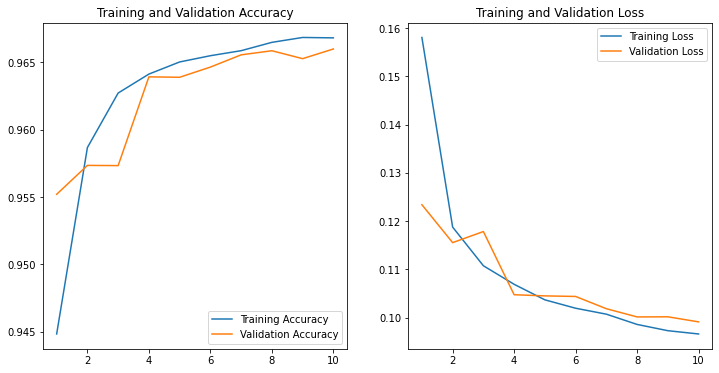

In [19]:
acc = nn1_history.history['acc']
val_acc = nn1_history.history['val_acc']

loss = nn1_history.history['loss']
val_loss = nn1_history.history['val_loss']

epochs_range = range(1,11)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.ylim(0.90, 1.00)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Neural Network 2 (with early stopping, without dropout layer)

In [20]:
nn2 = keras.Sequential([                 
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn2.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['acc'])

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 5 epochs"
        patience=3,
        verbose=1,
    )
]

nn2_history = nn2.fit(
    x = X_train, 
    y = y_train,
    batch_size = 128, 
    epochs=10,
    callbacks = callbacks,
    validation_split = 0.3 )

Epoch 1/10
2386/2386 [==============================] - 11s 5ms/step - loss: 0.1626 - acc: 0.9448 - val_loss: 0.1227 - val_acc: 0.9552
Epoch 2/10
2386/2386 [==============================] - 13s 5ms/step - loss: 0.1173 - acc: 0.9608 - val_loss: 0.1102 - val_acc: 0.9627
Epoch 3/10
2386/2386 [==============================] - 13s 5ms/step - loss: 0.1096 - acc: 0.9633 - val_loss: 0.1102 - val_acc: 0.9628
Epoch 4/10
2386/2386 [==============================] - 13s 5ms/step - loss: 0.1058 - acc: 0.9645 - val_loss: 0.1019 - val_acc: 0.9650
Epoch 5/10
2386/2386 [==============================] - 13s 5ms/step - loss: 0.1026 - acc: 0.9653 - val_loss: 0.1017 - val_acc: 0.9654
Epoch 5: early stopping


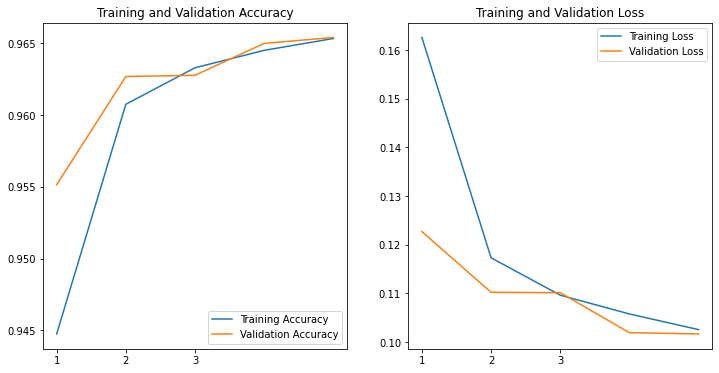

In [21]:
acc = nn2_history.history['acc']
val_acc = nn2_history.history['val_acc']

loss = nn2_history.history['loss']
val_loss = nn2_history.history['val_loss']

epochs_range = range(1,len(nn2_history.history['loss'])+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.ylim(0.96, 0.98)
plt.xticks([1,2,3])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks([1,2,3])
plt.title('Training and Validation Loss')
plt.show()

### Neural Network 3 (with early stopping, with dropout layer)

In [22]:
nn3 = keras.Sequential([                 
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.2, seed=110352028 ),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.2, seed=110352028 ),
    keras.layers.Dense(1, activation='sigmoid')
])

nn3.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['acc'])

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 5 epochs"
        patience=3,
        verbose=1,
    )
]

nn3_history = nn3.fit(
    x = X_train, 
    y = y_train,
    batch_size = 128, 
    epochs=10,
    callbacks = callbacks,
    validation_split = 0.3 )

Epoch 1/10
2386/2386 [==============================] - 18s 7ms/step - loss: 0.1866 - acc: 0.9365 - val_loss: 0.1308 - val_acc: 0.9529
Epoch 2/10
2386/2386 [==============================] - 17s 7ms/step - loss: 0.1364 - acc: 0.9528 - val_loss: 0.1212 - val_acc: 0.9547
Epoch 3/10
2386/2386 [==============================] - 17s 7ms/step - loss: 0.1254 - acc: 0.9578 - val_loss: 0.1117 - val_acc: 0.9614
Epoch 4/10
2386/2386 [==============================] - 17s 7ms/step - loss: 0.1205 - acc: 0.9596 - val_loss: 0.1084 - val_acc: 0.9635
Epoch 5/10
2386/2386 [==============================] - 18s 7ms/step - loss: 0.1165 - acc: 0.9610 - val_loss: 0.1060 - val_acc: 0.9634
Epoch 6/10
2386/2386 [==============================] - 17s 7ms/step - loss: 0.1148 - acc: 0.9619 - val_loss: 0.1051 - val_acc: 0.9636
Epoch 6: early stopping


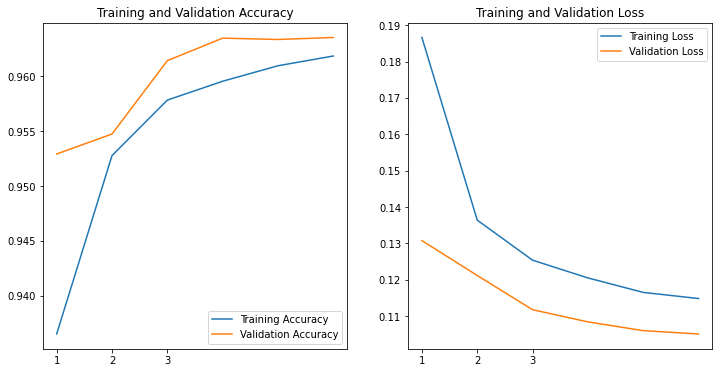

In [23]:
acc = nn3_history.history['acc']
val_acc = nn3_history.history['val_acc']

loss = nn3_history.history['loss']
val_loss = nn3_history.history['val_loss']

epochs_range = range(1,len(nn3_history.history['loss'])+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.ylim(0.96, 0.98)
plt.xticks([1,2,3])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks([1,2,3])
plt.title('Training and Validation Loss')
plt.show()

# 6. Evaluation

## Prediction Accuracy

In [24]:
nb_y = nb.predict(X_test)
lr_y = lr.predict(X_test)
dt_y = dt.predict(X_test)
rf_y = rf.predict(X_test)
xgb_y = xgb.predict(X_test)
nn1_y = list(map(lambda x: 0 if x < 0.5 else 1, nn1.predict(X_test)))
nn2_y = list(map(lambda x: 0 if x < 0.5 else 1, nn2.predict(X_test)))
nn3_y = list(map(lambda x: 0 if x < 0.5 else 1, nn3.predict(X_test)))

In [25]:
print('Classification report for naive bayes:')
print(classification_report(y_test, nb_y, digits=4))
print()
print('Classification report for logistic regression:')
print(classification_report(y_test, lr_y, digits=4))
print()
print('Classification report for decision tree:')
print(classification_report(y_test, dt_y, digits=4))
print()
print('Classification report for random forest:')
print(classification_report(y_test, rf_y, digits=4))
print()
print('Classification report for XGBoost:')
print(classification_report(y_test, xgb_y, digits=4))
print()
print('Classification report for Neural Network 1:')
print(classification_report(y_test, nn1_y, digits=4))
print()
print('Classification report for Neural Network 2:')
print(classification_report(y_test, nn2_y, digits=4))
print()
print('Classification report for Neural Network 3:')
print(classification_report(y_test, nn3_y, digits=4))
print()

Classification report for naive bayes:
              precision    recall  f1-score   support

           0     0.8867    0.9079    0.8972    141465
           1     0.8139    0.7765    0.7948     73429

    accuracy                         0.8630    214894
   macro avg     0.8503    0.8422    0.8460    214894
weighted avg     0.8618    0.8630    0.8622    214894


Classification report for logistic regression:
              precision    recall  f1-score   support

           0     0.8938    0.9600    0.9257    141465
           1     0.9102    0.7803    0.8402     73429

    accuracy                         0.8986    214894
   macro avg     0.9020    0.8702    0.8830    214894
weighted avg     0.8994    0.8986    0.8965    214894


Classification report for decision tree:
              precision    recall  f1-score   support

           0     0.9128    0.9585    0.9351    141465
           1     0.9116    0.8236    0.8654     73429

    accuracy                         0.9124    214894

## Confusion Matrix

In [26]:
def draw_Heatmap(title):
    fig=plt.figure(figsize=(25, 25))
    for i, clf in zip(range(1, columns*rows +1),matrix.keys()):
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(f'{clf}(Accuracy: {100*round(matrix[clf][0][0] + matrix[clf][1][1], 4):.2f}%)', fontsize=20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)
        sns.heatmap(matrix[clf], 
                  fmt='.2%',
                  annot=True,
                  annot_kws={"fontsize":25},
                  cmap="Blues",
                  linewidths=0.1,
                  linecolor='white')
    fig.suptitle(title)
    plt.show()

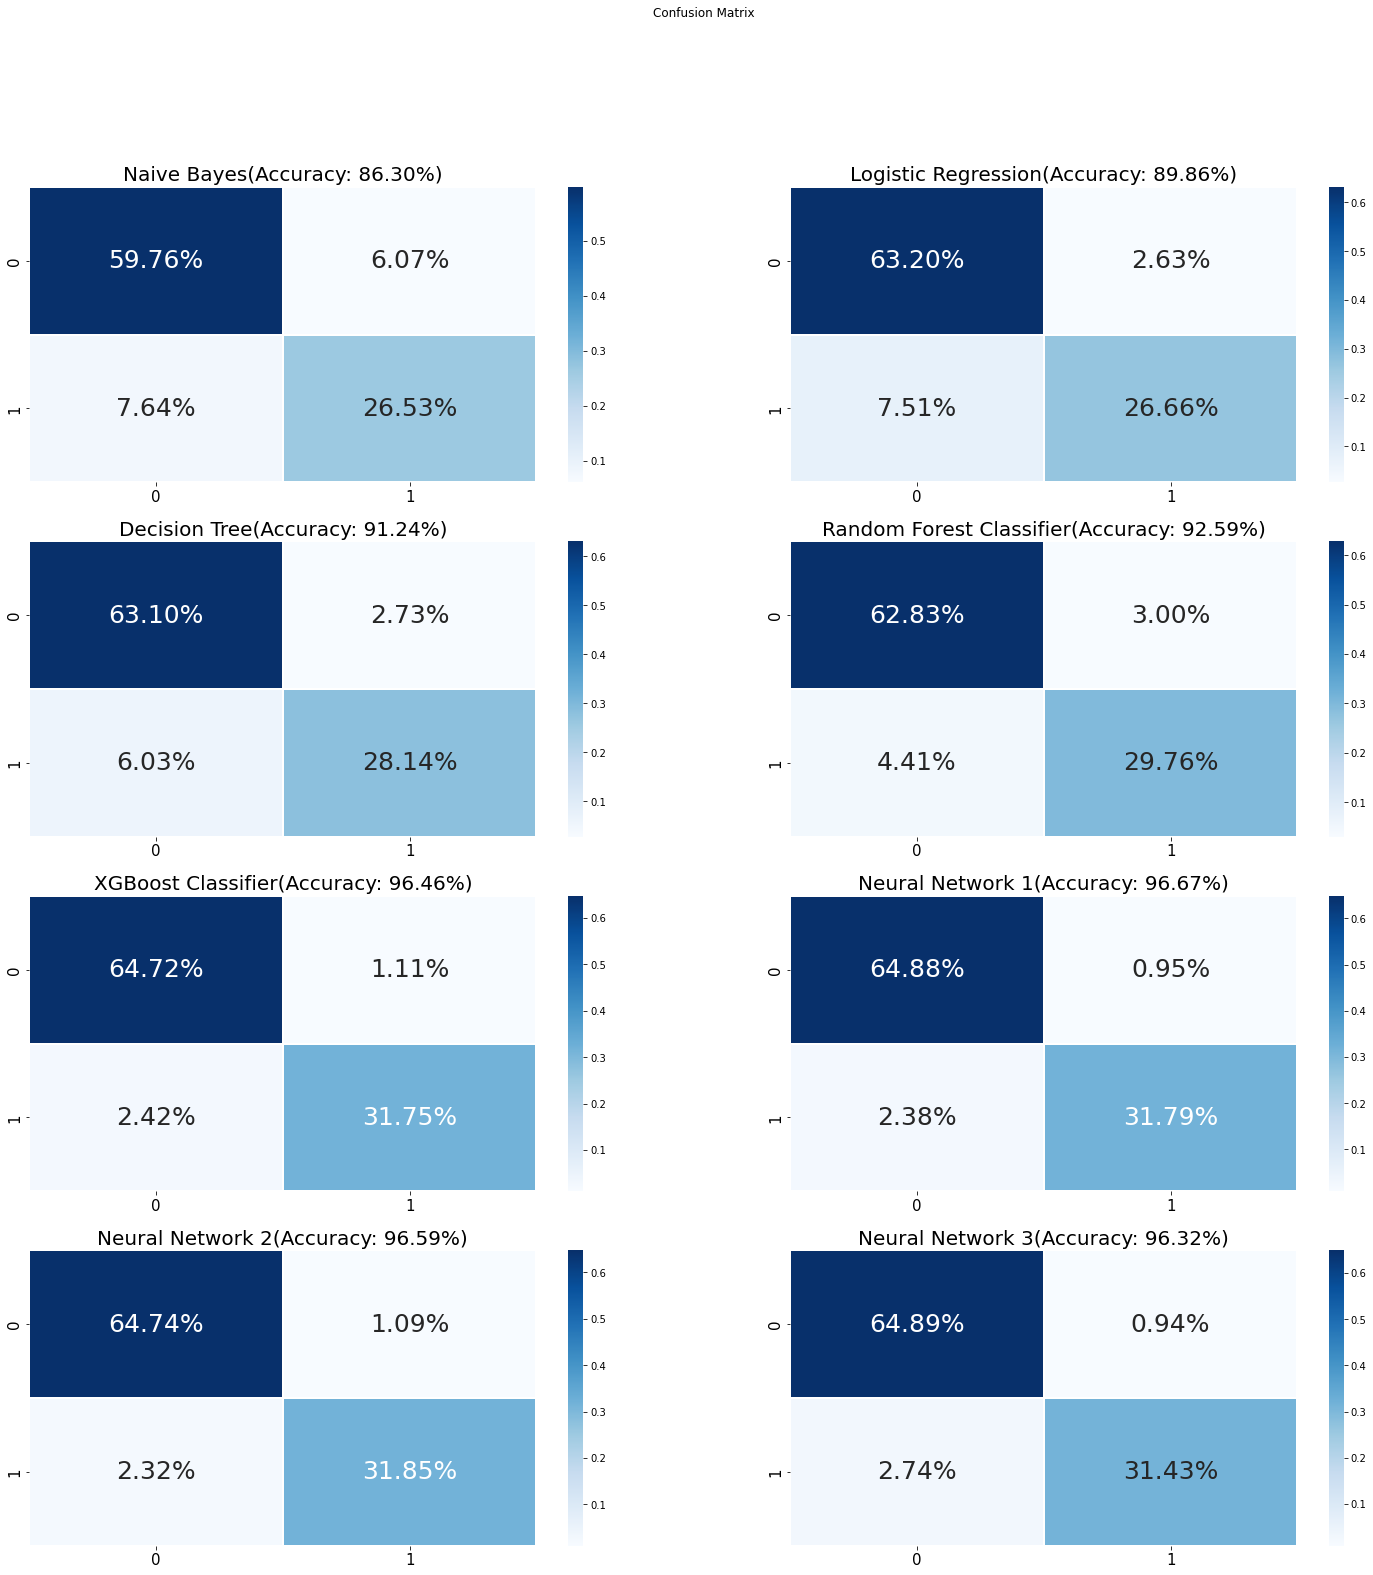

In [27]:
from sklearn import metrics

columns=2
rows=4

matrix = {'Naive Bayes':metrics.confusion_matrix(y_test, nb_y) / np.sum(metrics.confusion_matrix(y_test, nb_y)), 
          'Logistic Regression':metrics.confusion_matrix(y_test, lr_y) / np.sum(metrics.confusion_matrix(y_test, lr_y)),          
          'Decision Tree':metrics.confusion_matrix(y_test, dt_y) / np.sum(metrics.confusion_matrix(y_test, dt_y)), 
          'Random Forest Classifier':metrics.confusion_matrix(y_test, rf_y) / np.sum(metrics.confusion_matrix(y_test, rf_y)), 
          'XGBoost Classifier':metrics.confusion_matrix(y_test, xgb_y) / np.sum(metrics.confusion_matrix(y_test, xgb_y)), 
          'Neural Network 1':metrics.confusion_matrix(y_test, nn1_y) / np.sum(metrics.confusion_matrix(y_test, nn1_y)),
          'Neural Network 2':metrics.confusion_matrix(y_test, nn2_y) / np.sum(metrics.confusion_matrix(y_test, nn2_y)),
          'Neural Network 3':metrics.confusion_matrix(y_test, nn3_y) / np.sum(metrics.confusion_matrix(y_test, nn3_y))}
          
draw_Heatmap('Confusion Matrix')